# W14 PyTorch와 CNN으로 이미지 분류하기
### CNN 기반 이미지 분류 모델(SimpleCNN, ResNet)을 활용하기

* Dataset: EMNIST (balanced)
> * 손으로 쓰여진 숫자와 알파벳으로 구성된 데이터셋
> * 각 이미지는 가로 28 pixel, 세로 28 pixel로 총 28 * 28 pixel로 구성
> * 112,800개의 학습 이미지와 18,800개의 테스트 이미지로 구성
> * 47개의 클래스


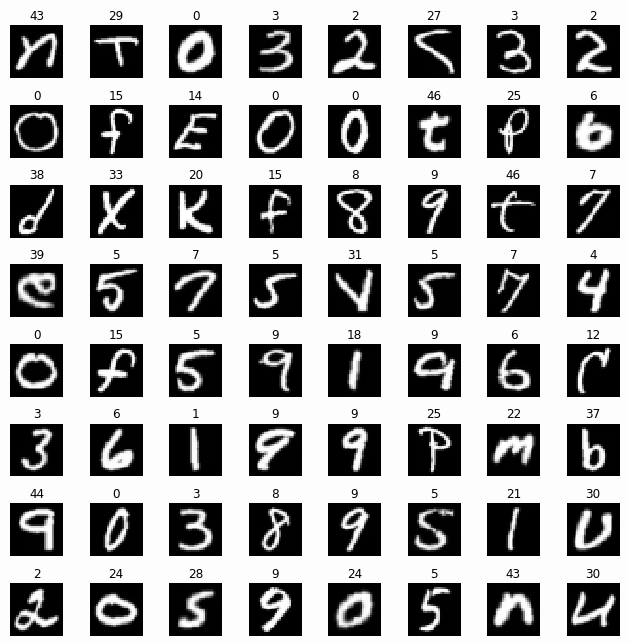

## Import

In [1]:
# 필요한 라이브러리들 import
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import EMNIST

## EMNIST 데이터셋 로드 및 전처리

In [2]:
# EMNIST 데이터셋 로드 및 전처리
# EMNIST 데이터셋 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 데이터셋의 평균 및 표준편차 변환
])

# EMNIST 데이터셋 다운로드
train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


In [ ]:
# 모델 학습과 테스트를 위한 데이터 로더
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# 데이터로더로 각 데이터의 형태 확인(총 수량, 채널 수, 높이, 너비)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

## 간단한 CNN 모델 정의
### 사용한 것들
> * conv : convolution layer, 합성곱 연산을 수행
> * fc : fully connected layer, input으로 받은 정보를 평탄화
> * relu : 활성화 함수
> * max_pool2d: pooling 연산으로 주요 정보는 유지하고 피쳐맵 크기 축소
> * view: 텐서의 모양변경

In [4]:
# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 47)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 학습과 테스트를 위한 함수 정의

In [5]:
# 모델 학습
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # dataloader에서 feature정보인 X와 대응되는 정답값 y를 연산을 수행할 장치에 할당

        # 예측 오류 계산
        pred = model(X) # X에 할당된 데이터에 대해 예측
        loss = loss_fn(pred, y) # 손실함수로 실제값 y와 예측값간 오차 계산

        # 역전파
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        # (option) 현재 학습상태 출력
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
# 모델 테스트
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 데이터 수 확인
    num_batches = len(dataloader) # 배치사이즈 확인

    # 학습이 아니라 평가 목적이므로 해당 모드로 변경
    model.eval()

    # 오차와 정답 수를 0으로 초기화, 지정
    test_loss, correct = 0, 0

    # 평가 (평가과정은 학습때처럼 기울기 계산 필요가 없으므로 no_grad()활용)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # 오차 합산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 맞춘 수 합산
    test_loss /= num_batches # test_loss에 저장된 오차를 배치수만큼 나누어 다시 test_loss에 저장
    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 학습

In [7]:
# CPU 혹은 GPU로 연산을 수행할 장치(device) 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


In [8]:
# 모델 객체 생성
model = SimpleCNN().to(device)

# 손실 함수와 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# epoch 설정
epochs = 10

# epoch수 만큼 학습을 위한 loop및 학습중 성능 확인을 위한 코드
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # 학습을 위해 만든 train 함수 사용
    test(test_dataloader, model, loss_fn) # 모델의 테스트를 위해 만든 test 함수 사용
print("Done!")

## 테스트 및 결과 시각화

In [24]:
import matplotlib.pyplot as plt
import numpy as np

classes = [str(i) for i in range(47)]

#이미지 결과 시각화를 위한 함수 정의
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    np_image = img.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))

    plt.imshow(np_image, cmap=plt.cm.binary)
    if predictions_array == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{classes[int(predictions_array)]}({classes[int(true_label)]})",
               color=color)

model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")

Accuracy: 84.8% 


In [ ]:
# 맞춘것은 파란색, 틀린 예측은 빨간색으로 표시하여 시각화
num_rows = 3
num_cols = 10
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(1,num_images+1):
    plt.subplot(num_rows, 2 * num_cols, i)
    plot_image(i, predictions[i], y_test, X_test)


plt.tight_layout()
plt.show()


# ResNet 활용

In [30]:
from torchvision.models import resnet18

# EMNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet은 일반적으로 224x224 크기의 입력을 기대합니다.
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 데이터셋의 평균 및 표준편차
])

train_dataset = EMNIST(root='./data',  split='balanced',train=True, download=False, transform=transform)
test_dataset = EMNIST(root='./data',  split='balanced',train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# ResNet 모델 불러오기
model = resnet18(pretrained=False,num_classes=47)  # 미리 학습된 가중치를 사용하지 않음
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 원래는 RGB입력을 받지만 EMNIST는 1차원 흑백이므로 처리 필요

# 모델을 GPU로 이동합니다.
model = model.to(device)

In [31]:
# 손실 함수와 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# epoch 설정
epochs = 5

# epoch수 만큼 학습을 위한 loop및 학습중 성능 확인을 위한 코드
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # 학습을 위해 만든 train 함수 사용
    test(test_dataloader, model, loss_fn) # 모델의 테스트를 위해 만든 test 함수 사용
print("Done!")

In [ ]:
model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")